# Explore Upset Plot intersections
```
aedavids@ucsc.edu
8/9/2022
```

ref:
- https://upsetplot.readthedocs.io/en/stable/api.html#dataset-loading-and-generation
- signatureGenesUpsetPlots.ipynb
- https://towardsdatascience.com/how-to-use-multiindex-in-pandas-to-level-up-your-analysis-aeac7f451fce
- https://towardsdatascience.com/5-minute-guide-to-pandas-pivot-tables-df2d02786886
- kimLab/unmappedReadsAnalysis/python/test/testUpSetPlotData.py
- https://github.com/jnothman/UpSetPlot

UpsetPlot uses a pandas data frame with hierarchical indexing. hierarchical is also known as multilevel indexing. It is hard to understand how to find the genes in the interesections

see findIntersectionElements()

In [1]:
from   matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import upsetplot as upsp

# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display, Image, IFrame

## Create simple test case

In [2]:
IFrame("UpSetPlotUnitTestVennDiagram.pdf", width=400, height=500)

In [3]:
def createTestData(): 
    '''
    The sets are like GTEx Tissue Types or TCGA cohorts
    '''
    s1 = set( ['a', 'b', 'c', 'd'] )
    s2 = set( [     'b', 'c',      'e', 'f', 'g', 'h'] )
    s3 = set( [                         'f', 'g',           'j', 'k'] )
    s4 = set( [          'c', 'd',           'g', 'h', 'i', 'j'] )

    # make sure we do not have order depend bugs
    setList  = [s1,     s4,   s2,   s3]
    setNames = ['s1', 's4', 's2', 's3']
    dataDict = { setNames[i] : setList[i] for i in range(len(setList)) }

    return( dataDict )
    
expectedSets = {'s1': {'a'}, 
             's4': {'i'}, 
             's2': {'e'}, 
             's3': {'k'}, 
             's1,s2': {'c', 'b'}, 
             's1,s4': {'c', 'd'}, 
             's2,s3': {'g', 'f'}, 
             's2,s4': {'c', 'h', 'g'}, 
             's3,s4': {'j', 'g'}, 
             's1,s2,s4': {'c'}, 
             's2,s3,s4': {'g'}
         }    

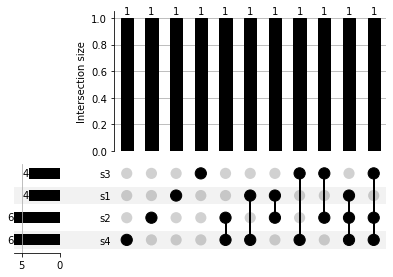

In [4]:
geneSetsDict = createTestData()
geneSetsUpsetPlotData = upsp.from_contents(geneSetsDict)
pltDict = upsp.UpSet(geneSetsUpsetPlotData, show_counts=True).plot()
fig = plt.gcf()

# Figure out how to use pandas multiindex levels to find genes in the interesections

The index.names in our test data are like GTEx tissue ids or TCGA cohorts in our GTEx_TCGA 1vsAll Datasets.

Notice the geneSetsUpsetPlotData has one column named 'id' this corresponds to a gene name.

In [5]:
geneSetsUpsetPlotData

id
s1    s4    s2    s3      
True  False False False  a
      True  True  False  c
            False False  d
      False True  False  b
False True  True  True   g
            False False  i
            True  False  h
            False True   j
      False True  True   f
                  False  e
            False True   k

In [6]:
geneSetsUpsetPlotData.index.names

FrozenList(['s1', 's4', 's2', 's3'])

In [7]:
for idx in geneSetsUpsetPlotData.index.values:
    print(idx)

(True, False, False, False)
(True, True, True, False)
(True, True, False, False)
(True, False, True, False)
(False, True, True, True)
(False, True, False, False)
(False, True, True, False)
(False, True, False, True)
(False, False, True, True)
(False, False, True, False)
(False, False, False, True)


In [8]:
geneSetsUpsetPlotData.columns

Index(['id'], dtype='object')

In [9]:
# s1 = set( ['a', 'b', 'c', 'd'] )
# only in s1 's1': {'a'}
# intersection 's1,s2': {'c', 'b'}, 
# intersection 's1,s4': {'c', 'd'}, 
inS1 = True
geneSetsUpsetPlotData.loc[(inS1), :]

id
s4    s2    s3      
False False False  a
True  True  False  c
      False False  d
False True  False  b

In [10]:
geneSetsUpsetPlotData.loc[(inS1), :].sum()

id    acdb
dtype: object

In [11]:
notInS1 = False
geneSetsUpsetPlotData.loc[(notInS1), :]

id
s4    s2    s3      
True  True  True   g
      False False  i
      True  False  h
      False True   j
False True  True   f
            False  e
      False True   k

# ? index as knock out?
for each intersection we can get the list of set names

In [12]:
setNames = list(geneSetsUpsetPlotData.index.names)
print("setNames is not in sort order")
setNames

setNames is not in sort order


['s1', 's4', 's2', 's3']

In [13]:
setNamesNP = np.asarray( setNames )
print( setNamesNP[ [True, True, False, True] ])

['s1' 's4' 's3']


In [14]:
for idx in geneSetsUpsetPlotData.index.values:
    print("\n********")
    print(idx)
#     print(type(idx))
#     print(type(idx[0]))
    arrayNP = np.asarray(idx)
    print(arrayNP)
    print(setNamesNP[arrayNP])
    #t = tuple(idx)
    display( geneSetsUpsetPlotData.loc[idx, :] )
    #display( geneSetsUpsetPlotData.loc[t, :].sum() )


********
(True, False, False, False)
[ True False False False]
['s1']


id    a
Name: (True, False, False, False), dtype: object


********
(True, True, True, False)
[ True  True  True False]
['s1' 's4' 's2']


id    c
Name: (True, True, True, False), dtype: object


********
(True, True, False, False)
[ True  True False False]
['s1' 's4']


id    d
Name: (True, True, False, False), dtype: object


********
(True, False, True, False)
[ True False  True False]
['s1' 's2']


id    b
Name: (True, False, True, False), dtype: object


********
(False, True, True, True)
[False  True  True  True]
['s4' 's2' 's3']


id    g
Name: (False, True, True, True), dtype: object


********
(False, True, False, False)
[False  True False False]
['s4']


id    i
Name: (False, True, False, False), dtype: object


********
(False, True, True, False)
[False  True  True False]
['s4' 's2']


id    h
Name: (False, True, True, False), dtype: object


********
(False, True, False, True)
[False  True False  True]
['s4' 's3']


id    j
Name: (False, True, False, True), dtype: object


********
(False, False, True, True)
[False False  True  True]
['s2' 's3']


id    f
Name: (False, False, True, True), dtype: object


********
(False, False, True, False)
[False False  True False]
['s2']


id    e
Name: (False, False, True, False), dtype: object


********
(False, False, False, True)
[False False False  True]
['s3']


id    k
Name: (False, False, False, True), dtype: object

## Find members for each intersection


In [15]:
print("setNamesNP is not in sort order")
setNamesNP

setNamesNP is not in sort order


array(['s1', 's4', 's2', 's3'], dtype='<U2')

In [16]:
idx = [ True, False,  True, False]
print(setNamesNP[idx])
print("loc out")
#geneSetsUpsetPlotData.loc[(True, False,  True, False),:]
# bug geneSetsUpsetPlotData.loc[idx,:]
# bug geneSetsUpsetPlotData.loc[np.asarray(idx),:]
display(geneSetsUpsetPlotData.loc[ tuple(idx),:] )
display(geneSetsUpsetPlotData.loc[ (True, slice(None), True, slice(None)),:] )

['s1' 's2']
loc out


id    b
Name: (True, False, True, False), dtype: object

id
s1   s4    s2   s3      
True True  True False  c
     False True False  b

In [17]:
def findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData):
    retDict = dict()
    retSingleSetDict = dict()
    
    # convert list to numpy array so we can use fancy array index
    setNames = list(geneSetsUpsetPlotData.index.names)
    setNamesNP = np.asarray(setNames)
    
    # for each intersection 
    for idx in geneSetsUpsetPlotData.index.values:
        #print("\n********")
        arrayNP = np.asarray(idx)
        
        # get the list of sets that the intersection was formed from 
        setNameList = sorted( setNamesNP[arrayNP] )
        setList = list()
        for sn in setNameList:
            setList.append( geneSetsDict[sn] )
            
        if len(setList) > 1:
            intersection = set.intersection( *setList )
            #print(intersection)
            key = ",".join(setNameList)
            retDict[ key ] = intersection
            
    # find elements that are not in an intersection
    n = len(setNamesNP)
    for i in range(0, n):
        testSetName = setNamesNP[i]
        knockOut = [True]*n 
        knockOut[i] = False # the name to knock out
        unionSetNameList = setNamesNP[ knockOut ]
        
        unionSetList = list()
        for u in unionSetNameList:
            unionSetList.append( geneSetsDict[u] )
            
        union = set.union( *unionSetList )
        testSet = geneSetsDict[testSetName]
        intersection = testSet.difference(union)
        
        if len(intersection) > 0:
            retSingleSetDict[testSetName] = intersection 
            
    return (retDict, retSingleSetDict)
    

geneSetsDict = createTestData()
geneSetsUpsetPlotData = upsp.from_contents(geneSetsDict)
retDict, retSingleSetDict  = findIntersectionElements(geneSetsDict, geneSetsUpsetPlotData)

print()
print(retDict )

print()
print( retSingleSetDict )


{'s1,s2,s4': {'c'}, 's1,s4': {'c', 'd'}, 's1,s2': {'b', 'c'}, 's2,s3,s4': {'g'}, 's2,s4': {'g', 'c', 'h'}, 's3,s4': {'g', 'j'}, 's2,s3': {'f', 'g'}}

{'s1': {'a'}, 's4': {'i'}, 's2': {'e'}, 's3': {'k'}}


In [18]:
retDict.update(retSingleSetDict)

assert retDict == expectedSets , 'ERROR'